# Predicting the Winner of El Clasico #236 (2017 Dec. 26)

This notebook presented before the el clasico #236 at Isfahan University of Technology for "El Clasico Day"

by Alireza Omidi | [Github](https://github.com/alirezaomidi) [Linkedin](linkedin.com/in/aomidi)

based on [Siraj Raval's work](https://github.com/llSourcell/Predicting_Winning_Teams)

## Import Dependencies

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

## Loading Data

In [2]:
data = pd.read_csv('laliga/final_dataset.csv', index_col=0)
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,...,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
0,2000-09-09,Barcelona,Malaga,2.0,1.0,H,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,2000-09-09,La Coruna,Ath Bilbao,2.0,0.0,H,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2000-09-09,Real Madrid,Valencia,2.0,1.0,H,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,2000-09-09,Sociedad,Santander,2.0,2.0,D,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,2000-09-09,Zaragoza,Espanol,1.0,2.0,A,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


## Data Exploration

In [3]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 6461
Number of features: 38
Number of matches won by home team: 3107
Win rate of home team: 48.09%


## Preparing the Data

In [4]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['FTR', 'FTHG', 'FTAG'], axis=1)
y_all = data['FTR']

In [5]:
#last 3 wins for both sides
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    '''Preprocesses the football data.'''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = col_data.astype('category').cat.codes
            col_data.rename(col, inplace=True)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (36 total features):
['Date', 'HomeTeam', 'AwayTeam', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts']


In [6]:
from sklearn.preprocessing import scale

X = scale(X_all)
X = pd.DataFrame(X, columns=X_all.columns)

In [7]:
# Show the feature information by printing the first five rows
print("Feature values:")
display(X_all.head())

Feature values:


,Date,HomeTeam,AwayTeam,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,...,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
0,0,5,21,0,0,0,0,0.0,0.0,2,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,0,17,3,0,0,0,0,0.0,0.0,2,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,0,27,34,0,0,0,0,0.0,0.0,2,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,0,31,29,0,0,0,0,0.0,0.0,2,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,0,39,12,0,0,0,0,0.0,0.0,2,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


In [8]:
X_elclasico = X_all.tail(1)
X_all.drop(X_all.tail(1).index, inplace=True)
y_all.drop(y_all.tail(1).index, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 50, stratify = y_all)

## Training and Evaluating Models

In [10]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, average=None), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {} , {}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {} , {}.".format(f1 , acc))

In [11]:
from sklearn.ensemble import AdaBoostClassifier
clf_A = SVC()
clf_B = AdaBoostClassifier(n_estimators=1000)
train_predict(clf_A, X_train, y_train, X_test, y_test)
print()
train_predict(clf_B, X_train, y_train, X_test, y_test)
# print()
# train_predict(clf_C, X_train, y_train, X_test, y_test)
# print()

Training a SVC using a training set size of 6410. . .
Trained model in 8.9746 seconds
Made predictions in 5.1612 seconds.
[0.99800285 0.99776857 0.99773389] 0.9978159126365055
F1 score and accuracy score for training set: [0.99800285 0.99776857 0.99773389] , 0.9978159126365055.
Made predictions in 0.0399 seconds.
F1 score and accuracy score for test set: [0.         0.15384615 0.65753425] , 0.5.

Training a AdaBoostClassifier using a training set size of 6410. . .


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 17.6869 seconds
Made predictions in 2.4721 seconds.
[0.47115385 0.26885246 0.69266358] 0.5681747269890796
F1 score and accuracy score for training set: [0.47115385 0.26885246 0.69266358] , 0.5681747269890796.
Made predictions in 0.1278 seconds.
F1 score and accuracy score for test set: [0.32       0.         0.60714286] , 0.42.


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf_B.predict(X_test)))

             precision    recall  f1-score   support

          A       0.36      0.29      0.32        14
          D       0.00      0.00      0.00        12
          H       0.53      0.71      0.61        24

avg / total       0.36      0.42      0.38        50



In [13]:
clf_B.predict(X_elclasico)

array(['D'], dtype=object)

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [10, 30, 50, 100, 200, 500, 1000], 'min_samples_split': [5, 10, 20, 50]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, scoring='f1_micro', cv=3, verbose=3, n_jobs=4)

grid_search = grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] min_samples_split=5, n_estimators=10 ............................
[CV] min_samples_split=5, n_estimators=10 ............................
[CV] min_samples_split=5, n_estimators=10 ............................
[CV] min_samples_split=5, n_estimators=30 ............................
[CV]  min_samples_split=5, n_estimators=10, score=0.46186242395882077, total=   0.3s
[CV]  min_samples_split=5, n_estimators=10, score=0.46725912067352665, total=   0.3s
[CV]  min_samples_split=5, n_estimators=10, score=0.46557377049180326, total=   0.3s
[CV] min_samples_split=5, n_estimators=30 ............................
[CV] min_samples_split=5, n_estimators=30 ............................
[CV] min_samples_split=5, n_estimators=50 ............................
[CV]  min_samples_split=5, n_estimators=30, score=0.49579045837231056, total=   0.7s
[CV] min_samples_split=5, n_estimators=50 ............................
[CV]  min_samples_split=5, n_es

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   20.5s


[CV]  min_samples_split=10, n_estimators=50, score=0.509822263797942, total=   0.8s
[CV] min_samples_split=10, n_estimators=50 ...........................
[CV]  min_samples_split=10, n_estimators=50, score=0.5025737014506317, total=   0.8s
[CV] min_samples_split=10, n_estimators=50 ...........................
[CV]  min_samples_split=10, n_estimators=50, score=0.4927400468384075, total=   0.8s
[CV] min_samples_split=10, n_estimators=100 ..........................
[CV]  min_samples_split=10, n_estimators=100, score=0.5046772684752104, total=   1.7s
[CV] min_samples_split=10, n_estimators=100 ..........................
[CV]  min_samples_split=10, n_estimators=100, score=0.5081890500701919, total=   1.7s
[CV] min_samples_split=10, n_estimators=100 ..........................
[CV]  min_samples_split=10, n_estimators=100, score=0.506791569086651, total=   1.7s
[CV] min_samples_split=10, n_estimators=200 ..........................
[CV]  min_samples_split=5, n_estimators=1000, score=0.507015902

[CV] min_samples_split=50, n_estimators=500 ..........................
[CV]  min_samples_split=20, n_estimators=1000, score=0.5091334894613583, total=  17.4s
[CV] min_samples_split=50, n_estimators=1000 .........................
[CV]  min_samples_split=50, n_estimators=500, score=0.5191768007483629, total=   7.0s
[CV] min_samples_split=50, n_estimators=1000 .........................
[CV]  min_samples_split=50, n_estimators=500, score=0.516612072999532, total=   7.2s
[CV] min_samples_split=50, n_estimators=1000 .........................
[CV]  min_samples_split=50, n_estimators=500, score=0.5166276346604215, total=   6.7s
[CV]  min_samples_split=50, n_estimators=1000, score=0.5191768007483629, total=  13.0s
[CV]  min_samples_split=50, n_estimators=1000, score=0.5175479644361254, total=  12.3s
[CV]  min_samples_split=50, n_estimators=1000, score=0.511943793911007, total=  10.6s


[Parallel(n_jobs=4)]: Done  84 out of  84 | elapsed:  1.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [15]:
print(classification_report(y_test, grid_search.predict(X_test)))

             precision    recall  f1-score   support

          A       0.70      0.50      0.58        14
          D       0.00      0.00      0.00        12
          H       0.56      0.92      0.70        24

avg / total       0.47      0.58      0.50        50



In [16]:
grid_search.predict(X_elclasico)

array(['A'], dtype=object)

## Conclusion

As you can see, the RandomForest has predicted that the away team (FC Barcelona) will win the game and its prediction precision is 70%.

P.S. At the end of the game, FC Barcelona won the el clasico 3-0. Cheers!

In [17]:
pd.Series(grid_search.best_estimator_.feature_importances_, index=X_all.columns)

Date             0.056228
HomeTeam         0.037792
AwayTeam         0.039829
HTGS             0.037842
ATGS             0.046626
HTGC             0.032473
ATGC             0.033631
HTP              0.068512
ATP              0.071270
HM1              0.006281
HM2              0.007926
HM3              0.009030
HM4              0.007860
HM5              0.008140
AM1              0.006023
AM2              0.007929
AM3              0.008550
AM4              0.008960
AM5              0.007436
MW               0.028384
HTFormPtsStr     0.044564
ATFormPtsStr     0.046075
HTFormPts        0.026533
ATFormPts        0.023747
HTWinStreak3     0.002040
HTWinStreak5     0.000529
HTLossStreak3    0.002517
HTLossStreak5    0.000531
ATWinStreak3     0.002152
ATWinStreak5     0.000998
ATLossStreak3    0.002034
ATLossStreak5    0.000376
HTGD             0.084751
ATGD             0.089135
DiffPts          0.093636
DiffFormPts      0.049660
dtype: float64

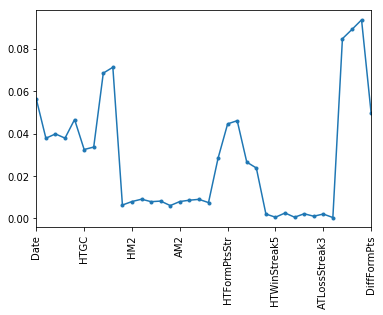

In [18]:
pd.Series(grid_search.best_estimator_.feature_importances_, index=X_all.columns).plot(rot=90, marker='.')